# KerasNLP Guide

KerasNLP is a natural language processing library that supports users through their entire development cycle. Our workflows are built from modular components that have state-of-the-art preset weights and architectures when used out-of-the-box and are easily customizable when more control is needed. We emphasize in-graph computation for all workflows so that developers can expect easy productionization using the TensorFlow ecosystem.

This library is an extension of the core Keras API; all high-level modules are `Layers` or `Models` that recieve that same level of polish as core Keras.

## Set up

Begin by installing and importing some necessary libraries, including: [KerasNLP](https://keras.io/keras_nlp/) for using various models and preprocessing components and [TensorFlow Datasets](https://www.tensorflow.org/datasets) to download one of the datasets we will be working with, the [AG News Dataset](https://www.tensorflow.org/datasets/catalog/ag_news_subset).

In [ ]:
!pip install keras_nlp datasets --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 337.5/337.5 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 95.5 MB/s eta 0:00:00


In [ ]:
import keras
import keras_nlp
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## Download the dataset

In [ ]:
ds = tfds.load('ag_news_subset', as_supervised=True) # ds['train] and ds['test] are tuples

Let's take a look at what the data looks like:

In [ ]:
for text, label in ds['train']:
  print(text.numpy())
  print(label.numpy())
  break

b'AMD #39;s new dual-core Opteron chip is designed mainly for corporate computing applications, including databases, Web services, and financial transactions.'
3


In [ ]:
# Batch the data
train_ds = ds['train'].batch(16)
test_ds = ds['test'].batch(16)

## Inference with a pre-trained classifier

Our first task is to try running a sample of text with a pre-trained [BERT classifier](https://arxiv.org/abs/1810.04805). BERT and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

In [ ]:
# Create a BERT classifier to fit your data
classifier = keras_nlp.models.BertClassifier.from_preset(preset="bert_medium_en_uncased",
                                                         num_classes=4)

165657088/165657088 [==============================] - 1s 0us/step


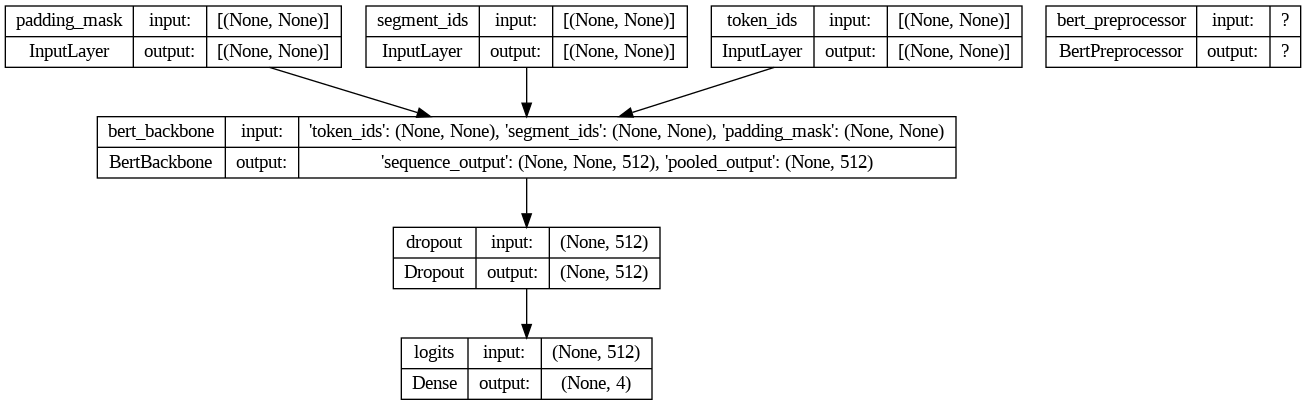

In [ ]:
tf.keras.utils.plot_model(classifier, show_shapes=True)

In [ ]:
classifier.predict([text])

1/1 [==============================] - 4s 4s/step


array([[0.0906518 , 0.07575043, 0.18867147, 0.2883668 ]], dtype=float32)

In [ ]:
np.argmax(classifier.predict([text]))

1/1 [==============================] - 1s 687ms/step


3

Let's try compiling the model and observing how it performs on the test dataset.

In [ ]:
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=keras.metrics.SparseCategoricalAccuracy(),
    jit_compile=True
)

We have a 23% accuracy, but let's remember this model hasn't been trained on this specific dataset. Let's continue exploring other levels of usage of KerasNLP to see how it performs on the dataset.

In [ ]:
classifier.evaluate(test_ds, return_dict=True)

475/475 [==============================] - 83s 156ms/step - loss: 1.4002 - sparse_categorical_accuracy: 0.2350


{'loss': 1.4001916646957397,
 'sparse_categorical_accuracy': 0.23500001430511475}

## Fine tuning a pre-trained BERT backbone

When labeled text specific to our task is available, fine-tuning a custom classifier can improve performance. If we want to predict what category an AG News title belongs to, it helps to fit it to the AG News dataset. IFor many tasks no relevant pretrained model will be available (e.g., categorizing customer reviews), so we can consider fine-tuning to be an option.

In [ ]:
# Recall the BERT classifier we created a couple cell blocks ago
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
    metrics=keras.metrics.SparseCategoricalAccuracy(),
    jit_compile=True,
)

Notice the huge jump in accuracy. We went from 23% to almost 90%. This is in part due to fine tuning.

In [ ]:
history = classifier.fit(train_ds,
                         validation_data=test_ds,
                         epochs=1)

7500/7500 [==============================] - 4321s 571ms/step - loss: 0.3146 - sparse_categorical_accuracy: 0.8965 - val_loss: 0.2683 - val_sparse_categorical_accuracy: 0.9162


## Fine tuning with user-controlled preprocessing

For some advanced training scenarios, users might prefer direct control over preprocessing. For large datasets, examples can be preprocessed in advance and saved to disk or preprocessed by a separate worker pool using tf.data.experimental.service. In other cases, custom preprocessing is needed to handle the inputs.

Pass `preprocessor=None` to the constructor of a task `Model` to skip automatic preprocessing or pass a custom `BertPreprocessor` instead.

### Separate preprocessing from the same preset

Each model architecture has a parallel __preprocessor__ `Layer` with its own `from_preset` constructor. Using the same __preset__ for this `Layer` will return the matching preprocessor as the task.

In this workflow we train the model over three epochs using `tf.data.Dataset.cache()`, which computes the preprocessing once and caches the result before fitting begins.



In [ ]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset(
    "bert_medium_en_uncased",
    sequence_length=512
)

train_ds_cached = (
    train_ds.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
)

test_ds_cached = (
    test_ds.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
)

classifier = keras_nlp.models.BertClassifier.from_preset(preset="bert_medium_en_uncased",
                                                         preprocessor=None,
                                                         num_classes=4)

classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
    metrics=keras.metrics.SparseCategoricalAccuracy(),
    jit_compile=True,
)

classifier.fit(
    train_ds_cached,
    validation_data=test_ds_cached,
    epochs=3
)

Epoch 1/3
7500/7500 [==============================] - 4316s 571ms/step - loss: 0.3071 - sparse_categorical_accuracy: 0.8989 - val_loss: 0.2502 - val_sparse_categorical_accuracy: 0.9222
Epoch 2/3
7500/7500 [==============================] - 4317s 576ms/step - loss: 0.2254 - sparse_categorical_accuracy: 0.9287 - val_loss: 0.2670 - val_sparse_categorical_accuracy: 0.9203
Epoch 3/3
7500/7500 [==============================] - 4204s 561ms/step - loss: 0.1869 - sparse_categorical_accuracy: 0.9427 - val_loss: 0.2851 - val_sparse_categorical_accuracy: 0.9203


As you can see above, apply some preprocessing has further increased our accuracy over the three epochs. We're now at 94% accuracy, and the loss has also decreased.

### Custom preprocessing

In cases where custom preprocessing is required, we offer direct access to the `Tokenizer` class that maps raw strings to tokens. It also has a `from_preset()` constructor to get the vocabulary matching pretraining.

In [ ]:
# Tokenizer class maps raw strings to tokens
tokenizer = keras_nlp.models.BertTokenizer.from_preset("bert_medium_en_uncased")
tokenizer(["I would like to learn natural language processing",
           "Can you believe my improvement in training accuracy?"])

231508/231508 [==============================] - 0s 1us/step


<tf.RaggedTensor [[1045, 2052, 2066, 2000, 4553, 3019, 2653, 6364],
 [2064, 2017, 2903, 2026, 7620, 1999, 2731, 10640, 1029]]>

In [ ]:
packer = keras_nlp.layers.MultiSegmentPacker(
    start_value=tokenizer.cls_token_id,
    end_value=tokenizer.sep_token_id,
    sequence_length=64
)

In [ ]:
def preprocessor(x, y):
  token_ids, segment_ids = packer(tokenizer(x))
  x = {
      "token_ids": token_ids,
       "segment_ids": segment_ids,
       "padding_mask": token_ids != 0
  }
  return x, y

In [ ]:
train_ds_preprocessed = (
    train_ds.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
)

test_ds_preprocessed = (
    test_ds.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
)

In [ ]:
# Preprocessed example
print(train_ds_preprocessed.unbatch().take(1).get_single_element())

({'token_ids': <tf.Tensor: shape=(64,), dtype=int32, numpy=
array([  101,  2572,  2094,  1001,  4464,  1025,  1055,  2047,  7037,
        1011,  4563, 23569, 26534,  9090,  2003,  2881,  3701,  2005,
        5971,  9798,  5097,  1010,  2164, 17881,  1010,  4773,  2578,
        1010,  1998,  3361, 11817,  1012,   102,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)>, 'segment_ids': <tf.Tensor: shape=(64,), dtype=int32, numpy=
array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)>, 'padding_mask': <tf.Tensor: shape=(64,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  T

## Fine tuning with a custom model

For more advanced applications, an appropriate task `Model` may not be available. In this case we provide direct access to the backbone `Model`, which has its own `from_preset` constructor and can be composed with custom `Layer`s. This is a form of transfer learning.

A backbone `Model` does not include automatic preprocessing but can be paired with a matching preprocessor using the same preset as shown in the previous workflow.

In this workflow we experiment with freezing our backbone model and adding two trainable transfomer layers to adapt to the new input.

In [ ]:
preprocessor = keras_nlp.models.BertPreprocessor.from_preset("bert_medium_en_uncased")
backbone = keras_nlp.models.BertBackbone.from_preset("bert_medium_en_uncased")

In [ ]:
train_ds_preprocessed = (
    train_ds.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
)

test_ds_preprocessed = (
    test_ds.map(preprocessor, tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)
)

In [ ]:
backbone.trainable = False
inputs = backbone.input
sequence = backbone(inputs)["sequence_output"]
for _ in range(2):
  sequence = keras_nlp.layers.TransformerEncoder(
      num_heads=2,
      intermediate_dim=512,
      dropout=0.1
  )(sequence)

In [ ]:
# Use [CLS] token output to classify
outputs = keras.layers.Dense(2)(sequence[:, backbone.cls_token_index, :])

In [ ]:
model = keras.Model(inputs, outputs)
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
    metrics=keras.metrics.SparseCategoricalAccuracy(),
    jit_compile=True,
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 padding_mask (InputLayer)      [(None, None)]       0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, None)]       0           []                               
                                                                                                  
 token_ids (InputLayer)         [(None, None)]       0           []                               
                                                                                                  
 bert_backbone (BertBackbone)   {'sequence_output':  41373184    ['padding_mask[0][0]',           
                                 (None, None, 512),               'segment_ids[0][0]',        